In [2]:
import sys, os
from glob import glob
import re
import time
from datetime import datetime 
import pydot 
# import graphviz

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

import tensorflow as tf
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sb
import psutil

# Directly importing from tf.keras for convenience
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, MaxPool1D, AveragePooling1D, MaxPool2D,GlobalMaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling2D, concatenate

from scipy.special import softmax
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("--------- Sys Info ---------")
print(sys.version)
print(" ")
print("--------- Utility Info ---------")
print("Cpu Usage: " + str(psutil.cpu_percent()) + "%")
print("Memory Usage:")
print(psutil.virtual_memory())
print(" ")
print("--------- Package Versions ---------")
print("Tensorflow Version: " + tf.__version__)
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Matplotlib Version: " + mpl.__version__)
print(" ")
print("--------- Local Hardware ---------")
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

--------- Sys Info ---------
3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]
 
--------- Utility Info ---------
Cpu Usage: 2.9%
Memory Usage:
svmem(total=137302384640, available=121487024128, percent=11.5, used=15815360512, free=121487024128)
 
--------- Package Versions ---------
Tensorflow Version: 2.0.0
Numpy Version: 1.17.4
Pandas Version: 0.25.3
Matplotlib Version: 3.1.3
 
--------- Local Hardware ---------


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7381119048044112289, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9027596452
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 10371189705365627998
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 9027596452
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 14176228269500408669
 physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:41:00.0, compute capability: 7.5"]

In [37]:
class WaveNet:
    def __init__(self, 
                input_dim,
                denseWidth,
                activation_function,
                output_activation,
                lookback_length, 
                callbacks, 
                learning_rate, 
                momentum, 
                cost_function, 
                metrics, 
                optim):
        
        self.input_dim = input_dim 
        self.denseWidth = denseWidth
        self.activation_function = activation_function
        self.output_activation = output_activation
        self.lookback_length = lookback_length
        self.callbacks = callbacks 
        self.learning_rate = learning_rate 
        self.momentum = momentum 
        self.cost_function = cost_function
        self.metrics = metrics
        self.optim = optim
        
        self.model = None
        self.model_history = None
            
    def __prepare_input_layers(self):
      output = []
      for i in range(int(self.lookback_length)):
        output.append(Input(shape=(self.input_dim,)))
      return output

    def __define_model(self):

        model_inputs = self.__prepare_input_layers()
        layers = []
        model_outputs = []

        for i in range(np.log2(self.lookback_length).astype('int64')):
            
          layer_arr = []
        
          for j in range(int(self.lookback_length / 2**(i+1))):
                
            if i == 0:
                
              concat = concatenate([model_inputs[j*2], model_inputs[j*2+1]])
              layer_arr.append(Dense(denseWidth, 
                                     activation_function)(concat))
                
            elif (i > 0) and (i < (np.log2(lookback_length).astype('int64') - 1)):
                
              concat = concatenate([layers[i - 1][j*2], layers[i - 1][j*2+1]])
              layer_arr.append(Dense(denseWidth, 
                                     activation_function)(concat))
            else:
                
              concat = concatenate([layers[i - 1][j*2], layers[i - 1][j*2+1]])
              model_outputs.append(Dense(1, 
                                         output_activation)(concat))

          layers.append(layer_arr)

        self.model = Model(model_inputs, 
                           model_outputs[0])
    
    def __compile_model(self, nesterov=True):

        self.model.compile(optimizer=optim(learning_rate=self.learning_rate, 
                                      momentum=self.momentum, 
                                      nesterov=nesterov), 
                      loss=self.cost_function, 
                      metrics=self.metrics)

    
    def build_model(self):
        self.__define_model()
        self.__compile_model()
        
    def return_model(self):
        return self.model
    
    def __sequence_data_window(self, arr, start):
        end = start + self.lookback_length

        if ((end - start) % 2 != 0 or (end - start) < 0):
            raise Exception('Need evenly sized window')

        output = [np.array([arr[i]]).reshape(1,-1) for i in range(start, end)]
        return output


    def train_model(self, data):
      model_History = None
      for epoch in range(1):
        for i in range(0, len(data)-(self.lookback_length)):
            
          if(len(data)<self.lookback_length):
            raise Exception('Window Size must be lower than sequence length.')

          print(i)
          print(i+self.lookback_length)
            
          test_sequence = self.__sequence_data_window(data, i)
        
          print('-----------------------------')
          print(test_sequence)
          print(np.array([data[i+lookback_length]]))
            
          self.model_history = self.model.fit(test_sequence, np.array([data[i+self.lookback_length]]), epochs=1, batch_size = 1, callbacks=self.callbacks, verbose=False)
        
          print(self.model.predict(test_sequence)[0])
            
    def predict(self, data, time_steps):
        
        pred_data = data 
        while len(pred_data) < self.lookback_length:
            new_arr = [data[0]]
            new_arr += pred_data
            pred_data = new_arr
            

        for i in range(time_steps):
            current_pred_data = self.__sequence_data_window(pred_data, i)
            print(current_pred_data)
            prediction = self.model.predict(current_pred_data)
            pred_data.append(prediction)
            
            print(prediction)
            print(type(prediction))
            


def create_training_sequence(n, d):
    scaler = StandardScaler()

    sample = []

    power = np.random.normal(2, 1, 1)[0]
    base1 = np.random.normal(2, 0.5, 1)[0]
    base2 = 0
    for j in range(1, d):
      base1 += (j*2)
      base2 += base1**(power**2)
      sample.append(base1 + base2)

    sample = np.array(sample)
    sample -= np.mean(sample)
    sample /= np.std(sample)
    return np.array(sample)



input_dim = 1
denseWidth = 25
activation_function = 'relu'
output_activation = 'linear'
lookback_length = 8

earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)
callbacks = [earlyStoppingCallback]

learning_rate = 0.05
momentum = 0.6 

cost_function = 'MSE'
metrics = ['mse']
optim = SGD

wavenet = WaveNet(input_dim,
                denseWidth,
                activation_function,
                output_activation,
                lookback_length, 
                callbacks, 
                learning_rate, 
                momentum, 
                cost_function, 
                metrics, 
                optim)

wavenet.build_model()


In [38]:
test_data = create_training_sequence(1, 64)
model_History = wavenet.train_model(test_data)

0
8
-----------------------------
[array([[-0.52547783]]), array([[-0.52547783]]), array([[-0.52547782]]), array([[-0.52547782]]), array([[-0.52547779]]), array([[-0.52547772]]), array([[-0.52547752]]), array([[-0.52547707]])]
[-0.52547608]
[-0.20387259]
1
9
-----------------------------
[array([[-0.52547783]]), array([[-0.52547782]]), array([[-0.52547782]]), array([[-0.52547779]]), array([[-0.52547772]]), array([[-0.52547752]]), array([[-0.52547707]]), array([[-0.52547608]])]
[-0.52547413]
[-0.4383244]
2
10
-----------------------------
[array([[-0.52547782]]), array([[-0.52547782]]), array([[-0.52547779]]), array([[-0.52547772]]), array([[-0.52547752]]), array([[-0.52547707]]), array([[-0.52547608]]), array([[-0.52547413]])]
[-0.52547047]
[-0.5508989]
3
11
-----------------------------
[array([[-0.52547782]]), array([[-0.52547779]]), array([[-0.52547772]]), array([[-0.52547752]]), array([[-0.52547707]]), array([[-0.52547608]]), array([[-0.52547413]]), array([[-0.52547047]])]
[-0.5254

In [39]:
test = [1.03347762, 1.25336501, 1.49919952]

wavenet.predict(test, 4)

[array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.25336501]]), array([[1.49919952]])]
[[4.0853324]]
<class 'numpy.ndarray'>
[array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.25336501]]), array([[1.49919952]]), array([[4.0853324]], dtype=float32)]
[[5.735531]]
<class 'numpy.ndarray'>
[array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.25336501]]), array([[1.49919952]]), array([[4.0853324]], dtype=float32), array([[5.735531]], dtype=float32)]
[[7.8902445]]
<class 'numpy.ndarray'>
[array([[1.03347762]]), array([[1.03347762]]), array([[1.03347762]]), array([[1.25336501]]), array([[1.49919952]]), array([[4.0853324]], dtype=float32), array([[5.735531]], dtype=float32), array([[7.8902445]], dtype=float32)]
[[10.861944]]
<class 'numpy.ndarray'>


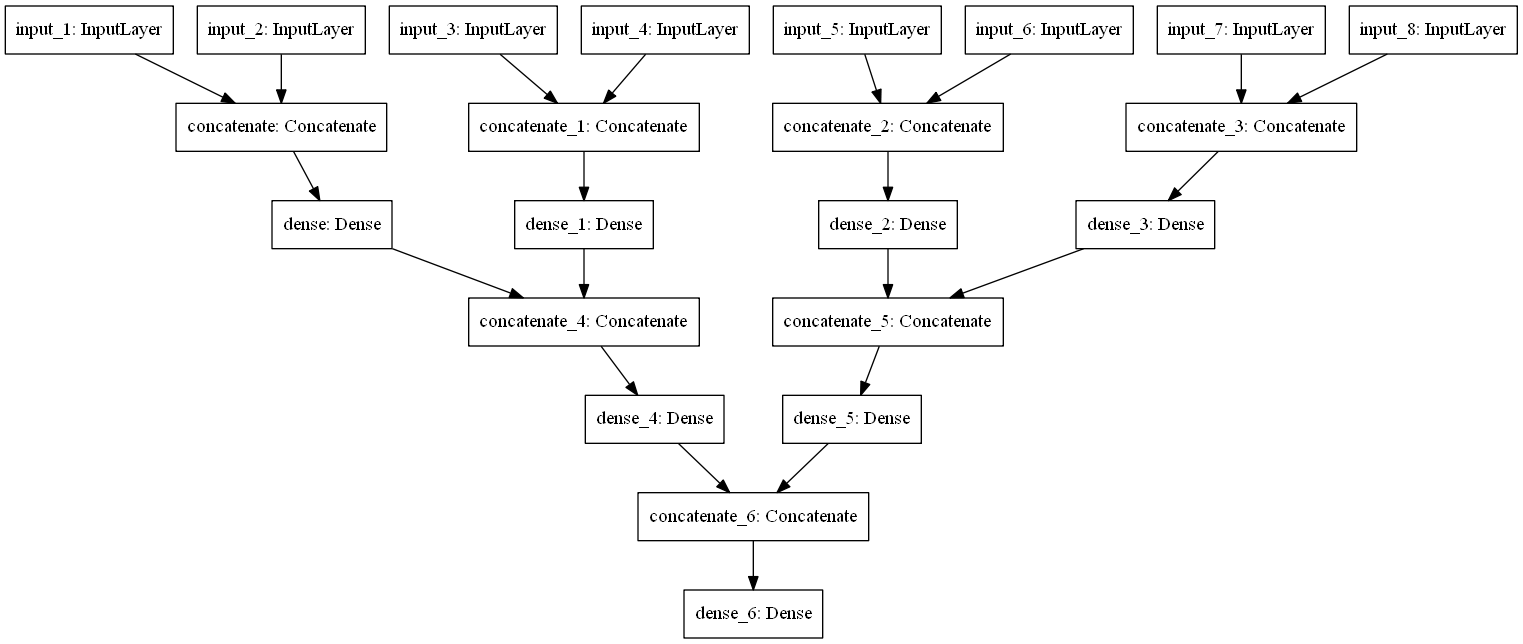

In [4]:
plot_model(wavenet.return_model())

[-0.38218366 -0.38218366 -0.38218366 -0.38218366 -0.38218366 -0.38218365
 -0.38218353 -0.3821828  -0.38217916 -0.38216348 -0.38210427 -0.38190359
 -0.38128342 -0.37951309 -0.37479657 -0.36296895 -0.33485486 -0.27113883
 -0.13277479  0.15634762  0.73979275  1.88041454  4.04659437]
<class 'numpy.ndarray'>
(23,)


[array([[-0.38218366]]), array([[-0.38218365]]), array([[-0.38218353]]), array([[-0.3821828]]), array([[-0.38217916]]), array([[-0.38216348]]), array([[-0.38210427]]), array([[-0.38190359]])]
<class 'list'>
<class 'numpy.ndarray'>
(1, 1)
